# 10. Integrating Polars Into the Data Science Workflow

By this point in this course, we've gained a lot of dexterity with `polars`; now, it's time to use it in a real data science problem!

The problem we will be trying to solve is **tip amount prediction**, using the NYC taxi rides data that we've been using throughout this course. The goal here is to provide a service to taxi drivers which, before starting a taxi ride, they can plug the details of their ride into, and receive a prediction for what tip amount that customer can be expected to pay. They could then use this information to inform themselves on how to best interact with their passengers to increase their tip; furthermore, feature importance insights from such a model could help a taxi driver decide the best places in the city to work, or the best times in the week, etc.

We'll go through the entire data science process:
1. Setting Up the Environment
2. Loading Data
4. Brief Data Exploration
3. Cleaning and Preparing the Data
4. Feature Engineering and Selection
5. Model Building
6. Model Evaluation
7. Discussion

Let's get into it!

## 10.1. Setting up the Environment

Import `polars` as usual...

In [2]:
import polars as pl

But also import some other tools from the data science suite that we'll need throughout this notebook.

In [8]:
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

Matplotlib is building the font cache; this may take a moment.


## 10.2. Loading Data

First, we load the data about zones:

In [9]:
zone_column_rename_mapping = {
    "LocationID": "location_id",
    "Borough": "borough",
    "Zone": "zone",
}
zones_df = (
    pl.read_parquet("../data/taxi_zone_lookup.parquet")
    .rename(zone_column_rename_mapping)
)

Then, we load in the yellow trips taxi data, for both february and march, joining in the zone information as before:

In [24]:
yellow_rides_column_rename_mapping = {
    "VendorID": "vendor_id",
    "RatecodeID": "ratecode_id",
    "PULocationID": "pu_location_id",
    "DOLocationID": "do_location_id",
    "Airport_fee": "airport_fee",
}

zone_df_columns = ["borough", "zone", "service_zone",]

rides_df_raw = (
    pl.read_parquet("../data/yellow_tripdata_2024-*.parquet")
    .rename(yellow_rides_column_rename_mapping)
    .join(zones_df, left_on="pu_location_id", right_on="location_id")
    .rename({zone_df_column: f"pu_{zone_df_column}" for zone_df_column in zone_df_columns})
    .join(zones_df, left_on="do_location_id", right_on="location_id")
    .rename({zone_df_column: f"do_{zone_df_column}" for zone_df_column in zone_df_columns})
)

In [25]:
display(rides_df_raw.shape)
display(rides_df_raw.head())

(6590154, 25)

vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pu_borough,pu_zone,pu_service_zone,do_borough,do_zone,do_service_zone
i32,datetime[ns],datetime[ns],i64,f64,i64,str,i32,i32,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str
2,2024-02-01 00:04:45,2024-02-01 00:19:58,1,4.39,1,"""N""",68,236,1,20.5,1.0,0.5,1.28,0.0,1.0,26.78,2.5,0.0,"""Manhattan""","""East Chelsea""","""Yellow Zone""","""Manhattan""","""Upper East Side North""","""Yellow Zone"""
2,2024-02-01 00:56:31,2024-02-01 01:10:53,1,7.71,1,"""N""",48,243,1,31.0,1.0,0.5,9.0,0.0,1.0,45.0,2.5,0.0,"""Manhattan""","""Clinton East""","""Yellow Zone""","""Manhattan""","""Washington Heights North""","""Boro Zone"""
2,2024-02-01 00:07:50,2024-02-01 00:43:12,2,28.69,2,"""N""",132,261,2,70.0,0.0,0.5,0.0,6.94,1.0,82.69,2.5,1.75,"""Queens""","""JFK Airport""","""Airports""","""Manhattan""","""World Trade Center""","""Yellow Zone"""
1,2024-02-01 00:01:49,2024-02-01 00:10:47,1,1.1,1,"""N""",161,163,1,9.3,3.5,0.5,2.85,0.0,1.0,17.15,2.5,0.0,"""Manhattan""","""Midtown Center""","""Yellow Zone""","""Manhattan""","""Midtown North""","""Yellow Zone"""
1,2024-02-01 00:37:35,2024-02-01 00:51:15,1,2.6,1,"""N""",246,79,2,15.6,3.5,0.5,0.0,0.0,1.0,20.6,2.5,0.0,"""Manhattan""","""West Chelsea/Hudson Yards""","""Yellow Zone""","""Manhattan""","""East Village""","""Yellow Zone"""


Looks good to go!

## 10.3. Brief Data Exploration

Before we proceed with any machine learning, let's first have a look at the data, viewed through the lens of the machine learning problem we're going to solve, keeping an eye out for anything we'll need to take care of during data cleaning and preparation:

In [35]:
rides_df_raw.describe()

statistic,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pu_borough,pu_zone,pu_service_zone,do_borough,do_zone,do_service_zone
str,f64,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str
"""count""",6.590154e6,"""6590154""","""6590154""",5.978354e6,6.590154e6,5.978354e6,"""5978354""",6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,6.590154e6,5.978354e6,5.978354e6,"""6590154""","""6590154""","""6590154""","""6590154""","""6590154""","""6590154"""
"""null_count""",0.0,"""0""","""0""",611800.0,0.0,611800.0,"""611800""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,611800.0,611800.0,"""0""","""0""","""0""","""0""","""0""","""0"""
"""mean""",1.756811,"""2024-03-02 23:29:08.306262""","""2024-03-02 23:45:29.766303""",1.332109,4.217783,2.189424,null,164.836847,163.769507,1.103447,18.39262,1.400976,0.48309,3.241934,0.526057,0.974779,26.894141,2.259032,0.136208,null,null,null,null,null,null
"""std""",0.430632,null,null,0.836458,281.631336,10.395004,null,64.242165,69.446392,0.622692,18.359656,1.804078,0.119625,3.941163,2.122793,0.221227,22.897657,0.826409,0.48108,null,null,null,null,null,null
"""min""",1.0,"""2002-12-31 22:17:10""","""2002-12-31 22:42:24""",0.0,0.0,1.0,"""N""",1.0,1.0,0.0,-999.0,-7.5,-0.5,-300.0,-84.3,-1.0,-1000.0,-2.5,-1.75,"""Bronx""","""Allerton/Pelham Gardens""","""Airports""","""Bronx""","""Allerton/Pelham Gardens""","""Airports"""
"""25%""",2.0,"""2024-02-16 23:06:24""","""2024-02-16 23:22:02""",1.0,1.0,1.0,null,132.0,113.0,1.0,8.61,0.0,0.5,0.0,0.0,1.0,15.48,2.5,0.0,null,null,null,null,null,null
"""50%""",2.0,"""2024-03-03 14:05:02""","""2024-03-03 14:23:32""",1.0,1.71,1.0,null,162.0,162.0,1.0,13.5,1.0,0.5,2.6,0.0,1.0,20.43,2.5,0.0,null,null,null,null,null,null
"""75%""",2.0,"""2024-03-17 12:36:18""","""2024-03-17 12:54:35""",1.0,3.2,1.0,null,234.0,234.0,1.0,21.2,2.5,0.5,4.12,0.0,1.0,29.04,2.5,0.0,null,null,null,null,null,null
"""max""",6.0,"""2024-04-01 00:34:55""","""2024-04-02 18:08:46""",9.0,222478.29,99.0,"""Y""",265.0,265.0,4.0,9792.0,14.25,35.84,999.99,163.0,1.0,9792.0,2.5,1.75,"""Unknown""","""Yorkville West""","""Yellow Zone""","""Unknown""","""Yorkville West""","""Yellow Zone"""


A few notes:
- Some rides had pickup and dropoff times that took place outside of the data's known time range...
- A few columns are missing data, all in exactly `611800` rows (about `10%` of the data): `"passenger_count"`, `"ratecode_id"`, `"store_and_fwd_flag"`, `"congestion_surcharge"`, and `"airport_fee"`.
- Some 

First and foremost, what percentage of data is missing, rather than count?

In [26]:
rides_df_raw.select(pl.all().null_count() / pl.len())

vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecode_id,store_and_fwd_flag,pu_location_id,do_location_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pu_borough,pu_zone,pu_service_zone,do_borough,do_zone,do_service_zone
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.092835,0.0,0.092835,0.092835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092835,0.092835,0.0,0.0,0.0,0.0,0.0,0.0


It appears that about 10% of the rows are missing `"passenger_count"`, `"ratecode_id"`, `"store_and_fwd_flag"`, `"congestion_surcharge"`, and `"airport_fee"`.

In [28]:
cols_with_null = ["passenger_count", "ratecode_id", "store_and_fwd_flag", "congestion_surcharge", "airport_fee"]
rides_df_raw.select(
    pl.all_horizontal(pl.col(cols_with_null).is_null()).sum() / pl.len())

passenger_count
f64
0.092835


Indeed, they are all null together. We'll take care of this when it comes time to clean and prepare the data.

Next, let's plot an ECDF of the target variable. We can do this by passing a polars series to matplotlib:

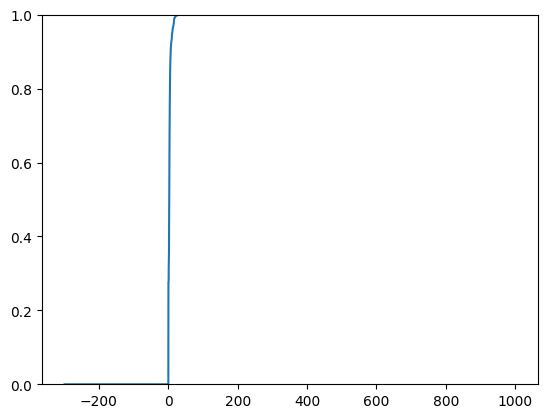

In [33]:
x = rides_df_raw["tip_amount"]
plt.ecdf(x)

Already we see some weird stuff with `"tip_amount"`--the highest tip 

## 10.3. Cleaning and Preparing the Data

Over the course of this course, we've compiled some filters of impossible data, such as rides without passengers, and rides that had a pickup that occurred after the dropoff. Let's filter those bad data out, first quantifying the scope of the issue:

In [18]:
remove_impossible_data_filter = (
    pl.col("tpep_pickup_datetime").lt(pl.col("tpep_dropoff_datetime")) &
    pl.col("passenger_count").gt(0)
)

In [19]:
rides_df_raw.select(remove_impossible_data_filter.mean().alias("fraction_data_usable"))

fraction_data_usable
f64
0.987248


Looks fine to remove!

While we're here, before we go

 However, we don't want to remove all the bad data just yet--**we only want to remove bad data from our train data**. This is because, when the model is performing live in the wild, we won't necessarily be guaranteed that the data will be clean in the way we'd like it to be; when taxi drivers use our system, perhaps they accidentally enter "0 passengers" 